In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [62]:
from __future__ import print_function
import SimpleITK as sitk

import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

import gui
import registration_gui as rgui
import registration_utilities as ru # 사용 위치 확인
import registration_callbacks as rc # 사용 위치 확인
import utilities as util

from ipywidgets import interact, fixed
from IPython.display import clear_output
import os

In [13]:
INPUT_DIR = 'SB-10222-1'
OUTPUT_DIR = 'output2'

if OUTPUT_DIR not in os.listdir():
    os.mkdir(OUTPUT_DIR)

#### 같은 영상 Modality 내? MeanSquares similarity metric을 사용하는게 적합하다

In [14]:
def bspline_intra_modal_registration(fixed_image, moving_image, fixed_image_mask=None, fixed_points=None, moving_points=None):

    registration_method = sitk.ImageRegistrationMethod()
    
    # Determine the number of BSpline control points using the physical spacing we want for the control grid. 
    grid_physical_spacing = [50.0, 50.0, 50.0] # A control point every 50mm
    image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]

    initial_transform = sitk.BSplineTransformInitializer(image1 = fixed_image, 
                                                         transformDomainMeshSize = mesh_size, order=3)    
    registration_method.SetInitialTransform(initial_transform)
        
    registration_method.SetMetricAsMeanSquares()
    # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be 
    # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # whole image.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    if fixed_image_mask:
        registration_method.SetMetricFixedMask(fixed_image_mask)
    
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)
    

    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_and_reference_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_and_reference_end_plot)
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_and_reference_plot_values(registration_method, fixed_points, moving_points))
    
    return registration_method.Execute(fixed_image, moving_image)

In [71]:
input_files = os.listdir(INPUT_DIR)

pt_id = []
ymdhm = []
modality = []
images = []

for filename in input_files:
    exp = filename.strip().split('.')[-1]
    if exp not in 'nii':
        continue
    
    new_pt_id = filename.strip().split('_')[0].replace('-','')
    new_ymdhm = filename.strip().split('_')[1]
    new_modality = filename.strip().replace('.','_').split('_')[2].replace(' ','')
    
    pt_id.append(new_pt_id)
    ymdhm.append(new_ymdhm)
    modality.append(new_modality)
    
    ymdhm=list(set(ymdhm))
    #print(min(ymdhm))
    #print(new_ymdhm)
    if new_ymdhm == min(ymdhm): 
        time='BF'
    else: time='AT'
    #print(time)
    globals()['i_{0}_{1}_{2}'.format(new_pt_id, new_modality, time)] = sitk.ReadImage(INPUT_DIR+ '/' + filename)
    images.append('i_{0}_{1}_{2}'.format(new_pt_id, new_modality, time))
    #gui.MultiImageDisplay([image], figure_size=(8,4))
    #print(filename)
    
pt_id=list(set(pt_id))
ymdhm=list(set(ymdhm))
modality=list(set(modality))
print(pt_id)
print(ymdhm)
print(modality)
print(images)

['SB102221']
['20191206170244', '20181114102050']
['T1GD', 'MPRAGE', 'spin', 'TOF', 'roll', 'T1', 'PD']
['i_SB102221_MPRAGE_BF', 'i_SB102221_T1_BF', 'i_SB102221_MPRAGE_AT', 'i_SB102221_T1_AT', 'i_SB102221_T1GD_BF', 'i_SB102221_TOF_BF', 'i_SB102221_roll_AT', 'i_SB102221_spin_AT', 'i_SB102221_spin_BF', 'i_SB102221_roll_BF', 'i_SB102221_PD_BF', 'i_SB102221_PD_AT', 'i_SB102221_T1GD_AT', 'i_SB102221_TOF_AT']


<IPython.core.display.Javascript object>


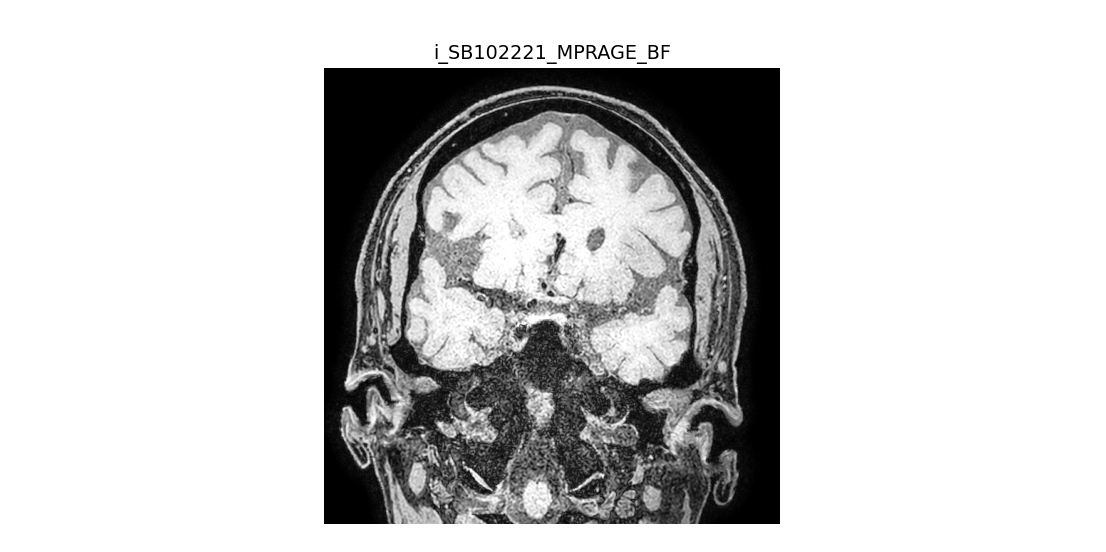

<IPython.core.display.Javascript object>


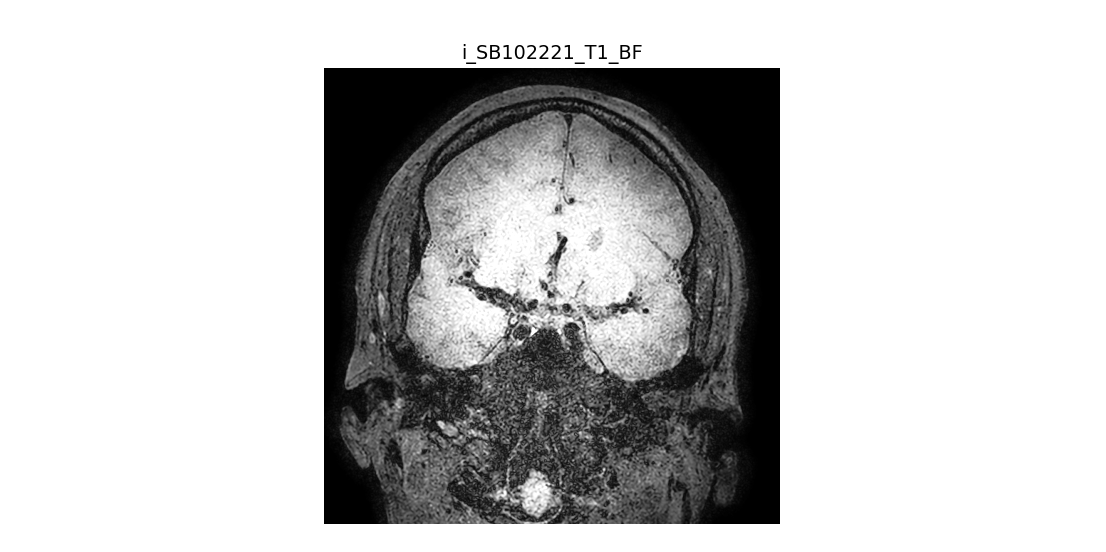

<IPython.core.display.Javascript object>


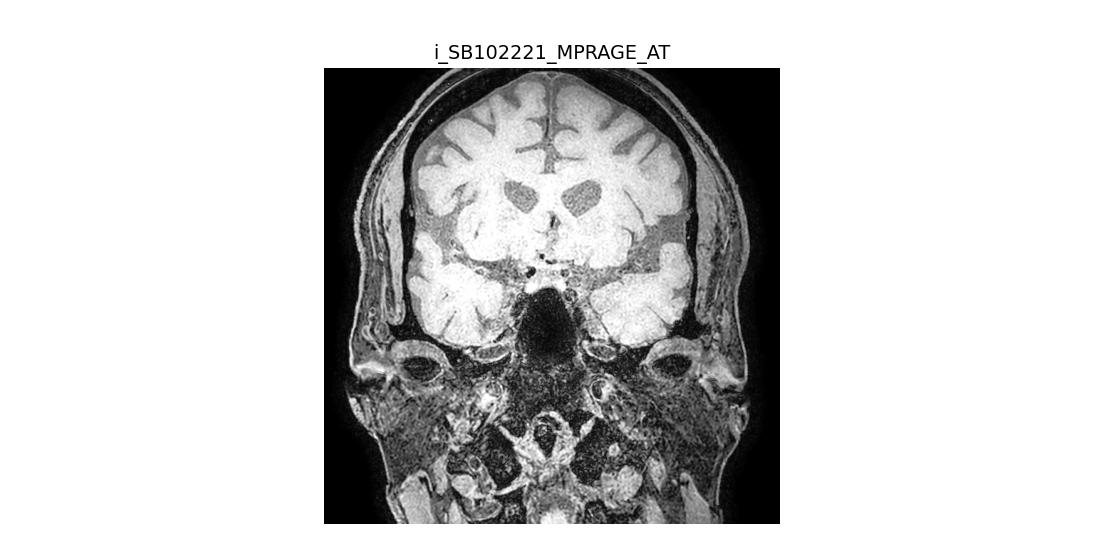

<IPython.core.display.Javascript object>


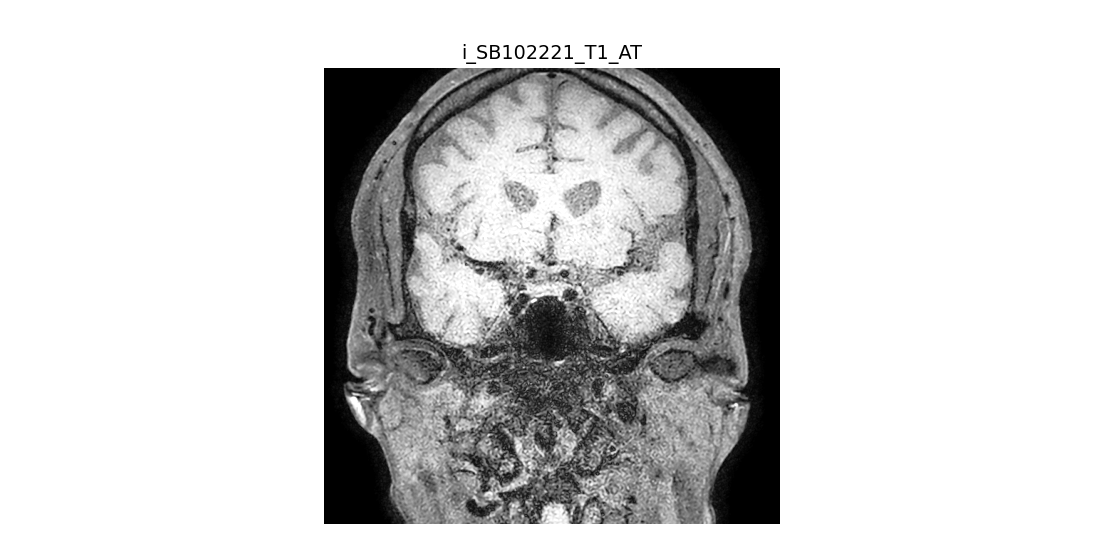

<IPython.core.display.Javascript object>


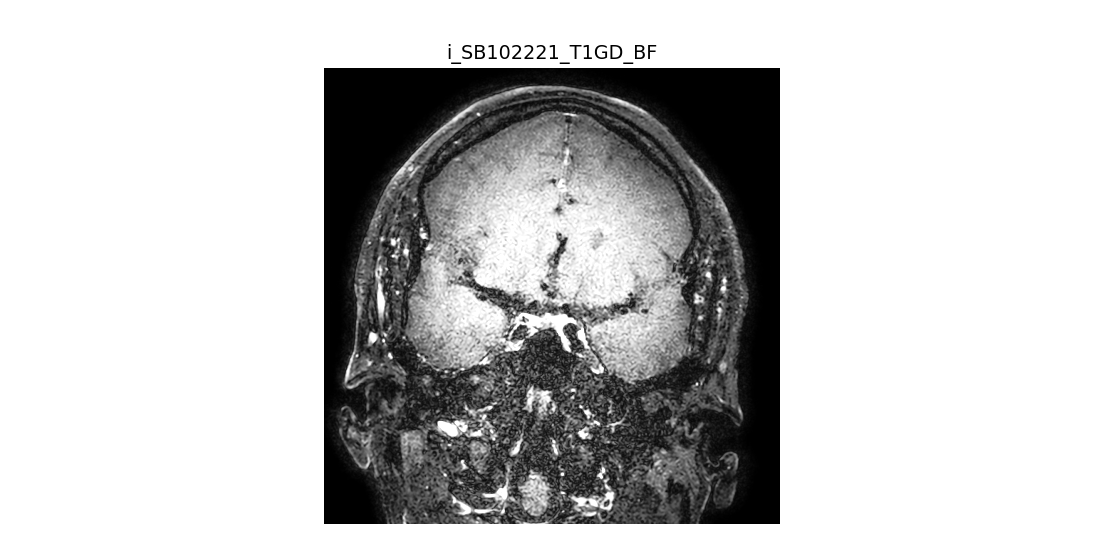

<IPython.core.display.Javascript object>


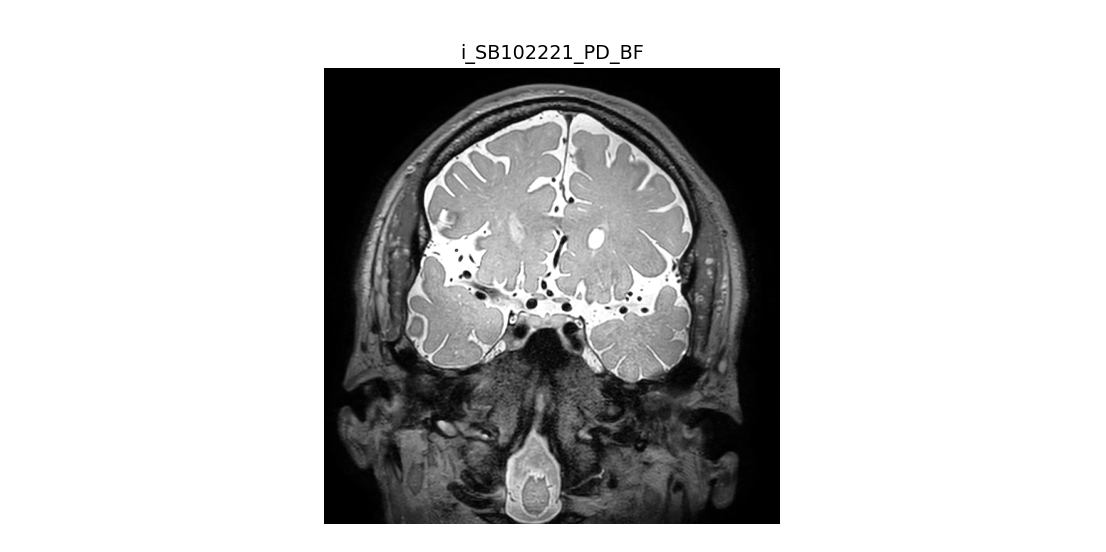

<IPython.core.display.Javascript object>


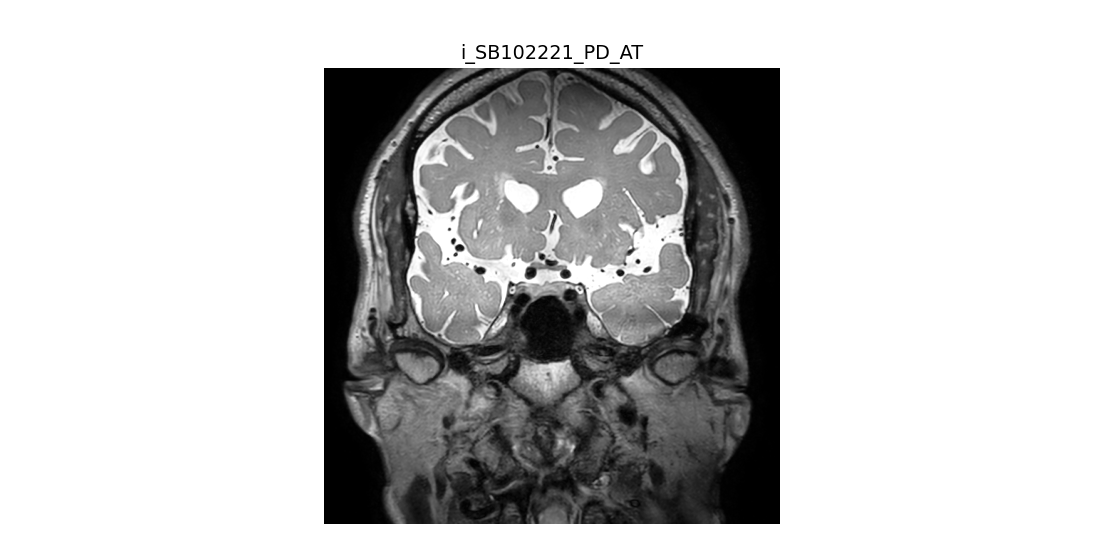

<IPython.core.display.Javascript object>


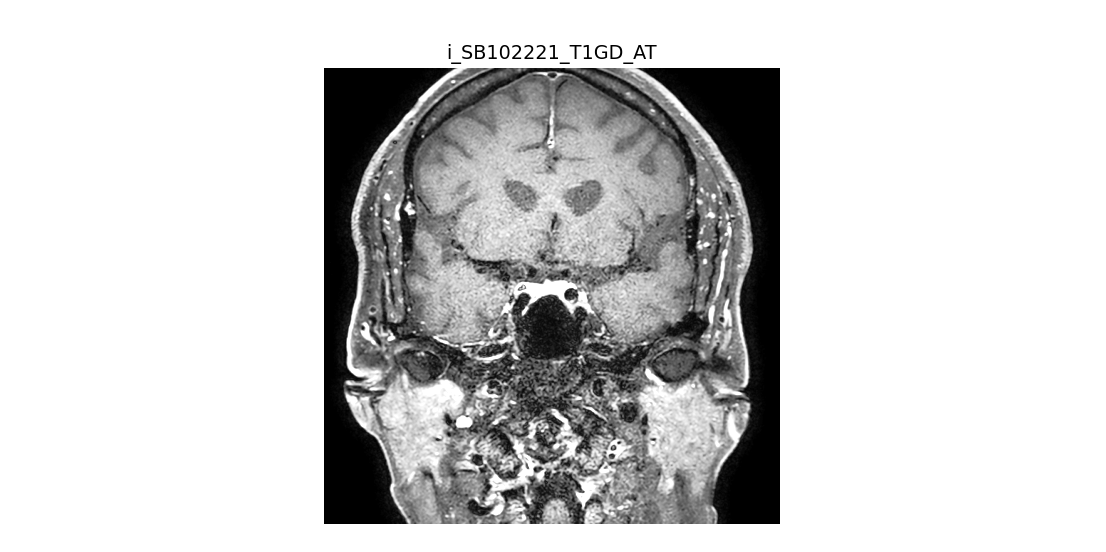

In [93]:
for i in images:
    if i.split('_')[-2] not in ['roll', 'spin', 'TOF']:
        gui.MultiImageDisplay([globals()[i]], title_list=[i], figure_size=(6,3))

<IPython.core.display.Javascript object>


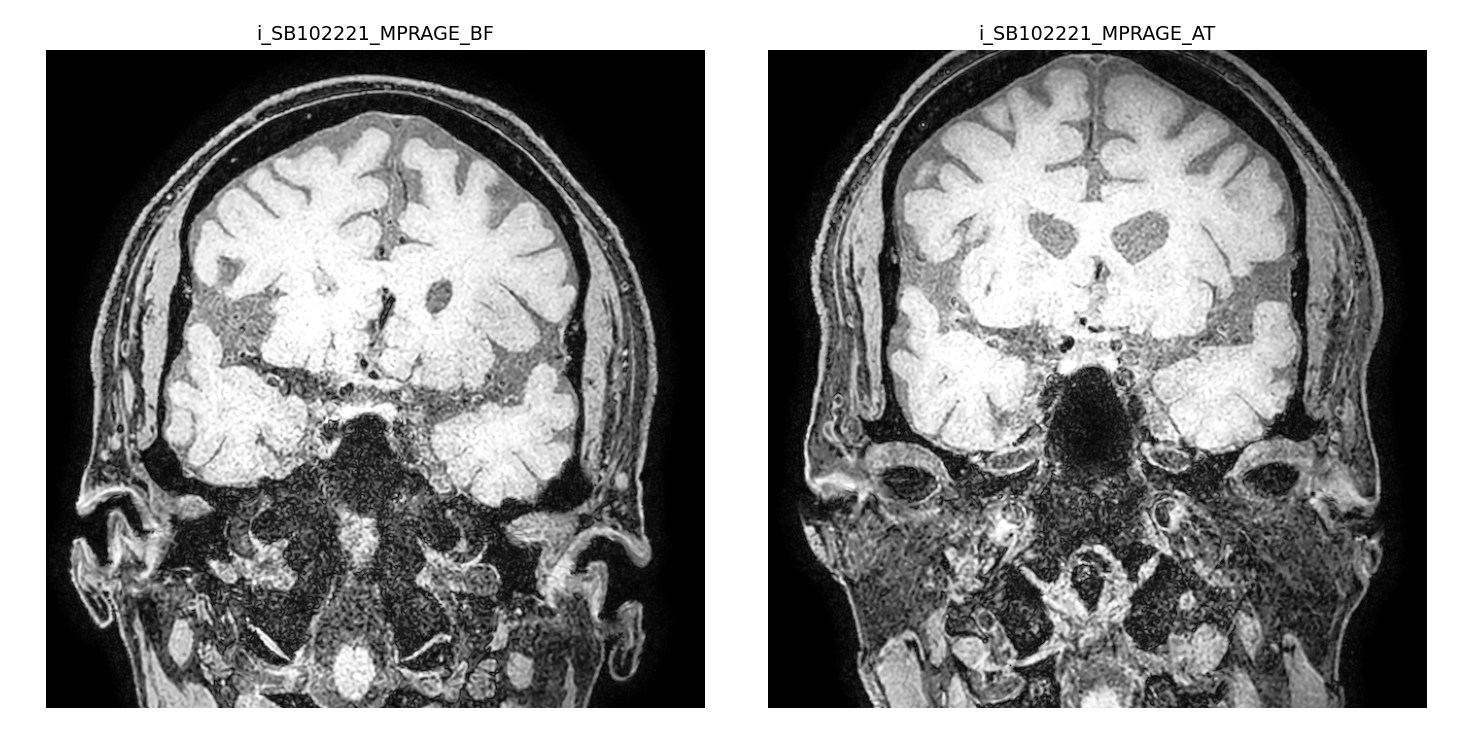

In [87]:
i_set = []
for i in images:
    if i.split('_')[-2] == 'MPRAGE':
        i_set.append(i)
gui.MultiImageDisplay([globals()[i_set[0]], globals()[i_set[1]]], title_list=[i_set[0],i_set[1]], figure_size=(8,4))

## registration

In [98]:
# This is the registration configuration which we use in all cases. The only parameter that we vary 
# is the initial_transform. 
def multires_registration(fixed_image, moving_image, initial_transform):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, estimateLearningRate=registration_method.Once)
    registration_method.SetOptimizerScalesFromPhysicalShift() 
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    final_transform = registration_method.Execute(fixed_image, moving_image)
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return (final_transform, registration_method.GetMetricValue())

<IPython.core.display.Javascript object>


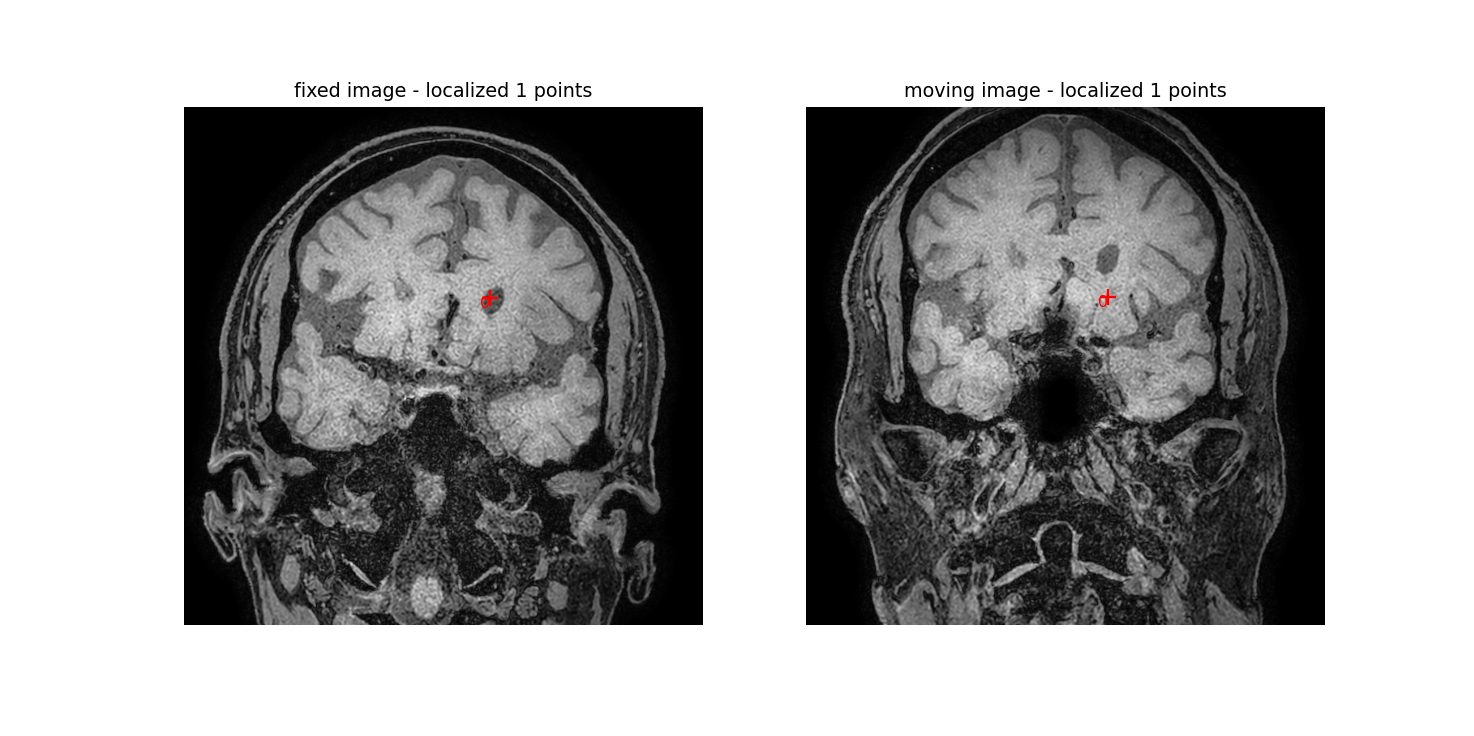

In [95]:
pt = 'SB102221'
mode = 'MPRAGE'
before = globals()['i_'+pt+'_'+mode+'_BF']
after = globals()['i_'+pt+'_'+mode+'_AT']

initial_transform = sitk.CenteredTransformInitializer(before, 
                                                      after, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

#gui.RegistrationPointDataAquisition(before, after, figure_size=(8,4), known_transformation=initial_transform)

In [99]:
multires_registration(before, after, initial_transform)

Final metric value: -0.6775552369306626
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


(<SimpleITK.SimpleITK.Transform; proxy of <Swig Object of type 'itk::simple::Transform *' at 0x7fe9fe43e900> >,
 -0.6775552369306626)

<IPython.core.display.Javascript object>


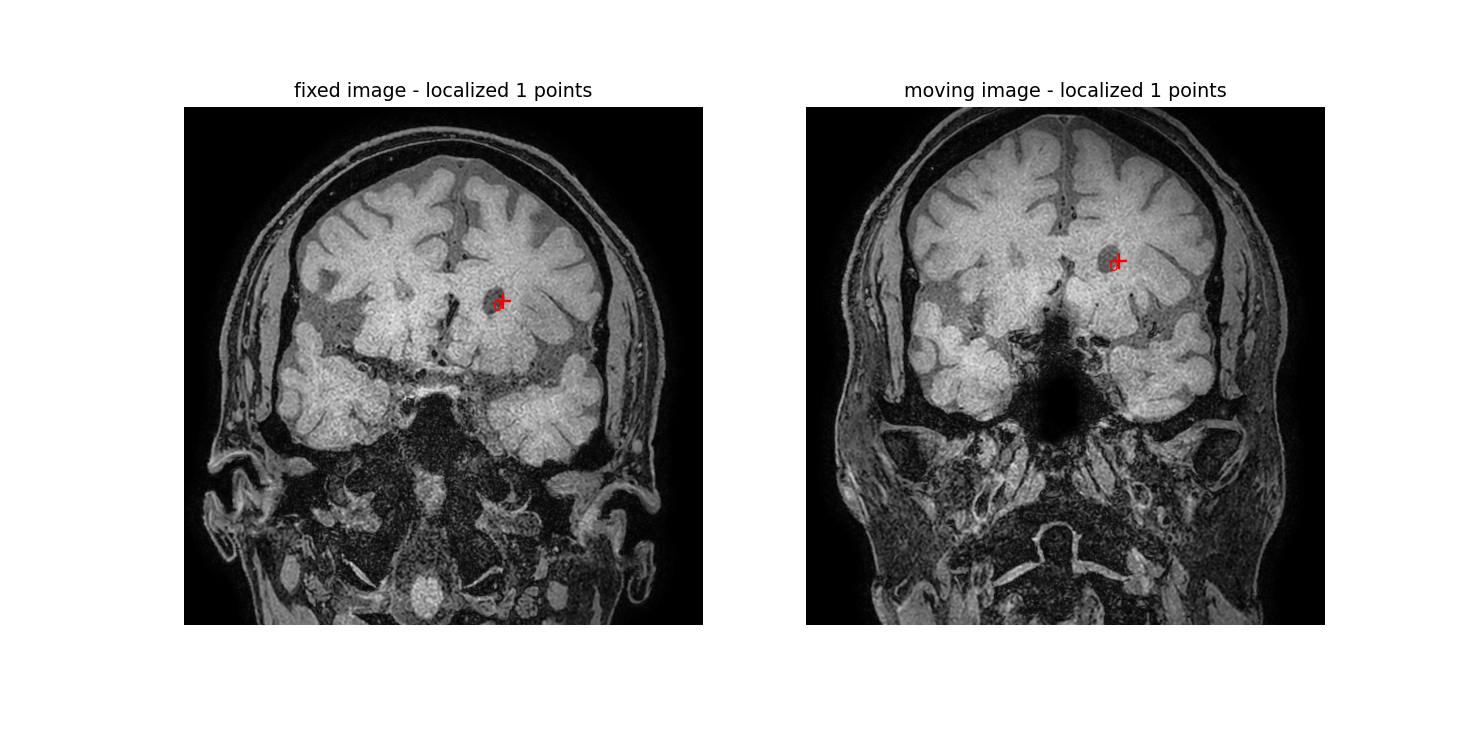

In [100]:
gui.RegistrationPointDataAquisition(before, after, 
                                    figure_size=(8,4), known_transformation=final_transform)

<IPython.core.display.Javascript object>


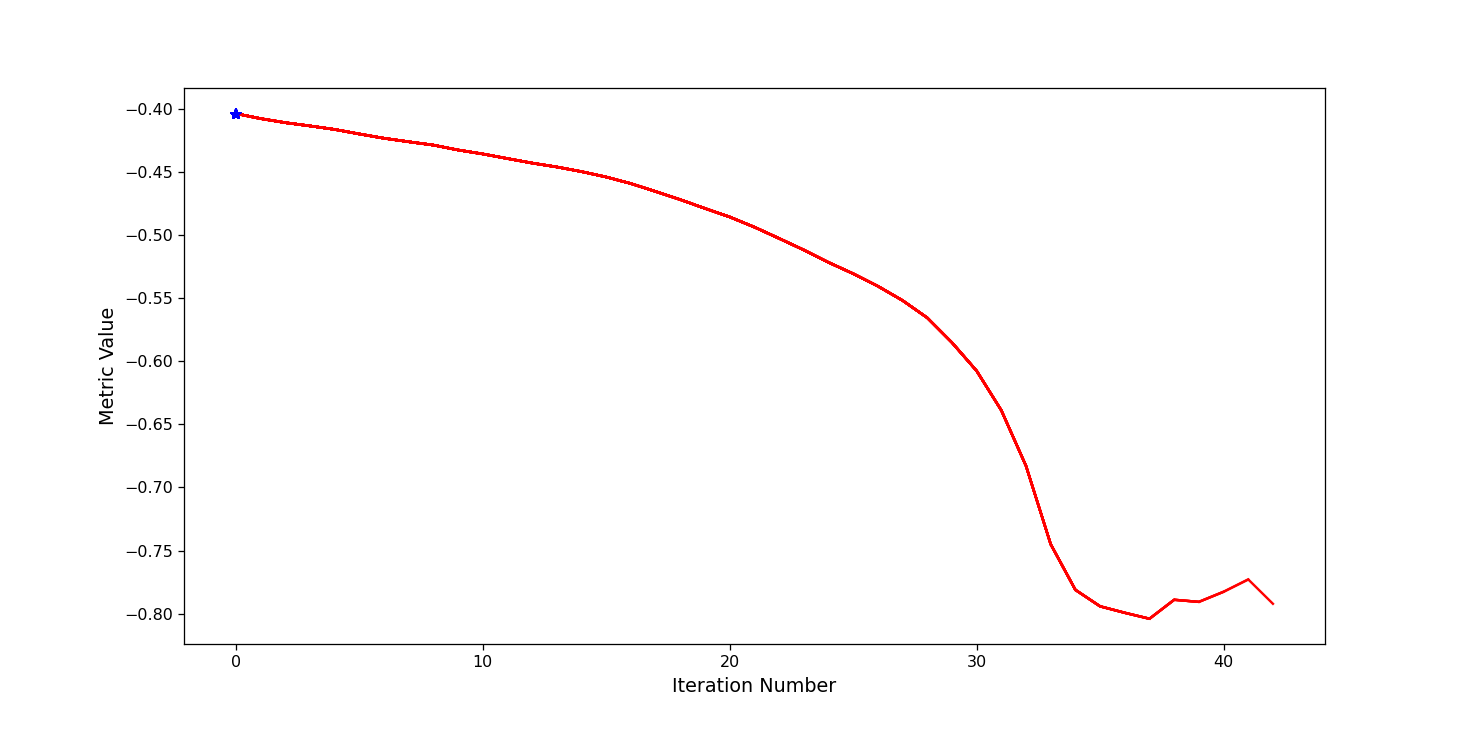

Final metric value: -0.7586364473818413
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 43.


In [96]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=1000, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
# registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
# registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
# registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method))

final_transform = registration_method.Execute(before, after)

# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

<IPython.core.display.Javascript object>


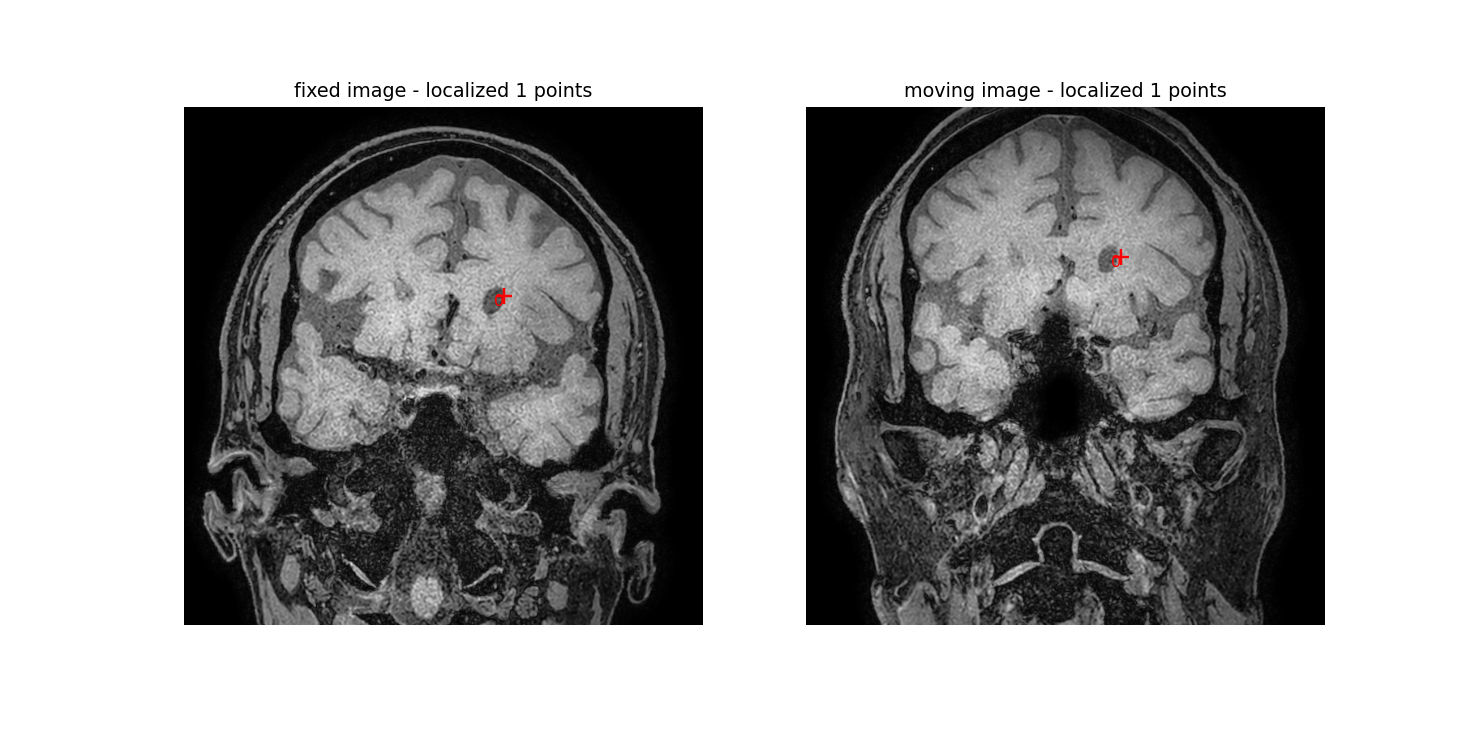

In [97]:
gui.RegistrationPointDataAquisition(before, after, 
                                    figure_size=(8,4), known_transformation=final_transform)